In [ ]:
@ARTICLE{2025arXiv251103636J,
       author = {{Jalali Kanafi}, M.~H. and {Movahed}, S.~M.~S.},
        title = "{Quantifying Weighted Morphological Content of Large-Scale Structures via Simulation-Based Inference}",
      journal = {arXiv e-prints},
     keywords = {Cosmology and Nongalactic Astrophysics, Machine Learning, Computational Physics},
         year = 2025,
        month = nov,
          eid = {arXiv:2511.03636},
        pages = {arXiv:2511.03636},
          doi = {10.48550/arXiv.2511.03636},
archivePrefix = {arXiv},
       eprint = {2511.03636},
 primaryClass = {astro-ph.CO},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2025arXiv251103636J},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

In [2]:
import numpy as np
import pylab as plt
import tqdm as tqdm
from tqdm import tqdm
import pickle
import torch
from sbi import utils as utils
from sbi.inference import SNPE
from sbi.neural_nets import posterior_nn
from sbi import analysis as analysis
import pandas as pd
import os
import dill 
import getdist
from getdist import plots, MCSamples

# Data description and problem explanation

Find the detail of BSQ simulation from 
https://quijote-simulations.readthedocs.io/en/latest/bsq.html

In [7]:
pos_halo = np.loadtxt('./data/pos_halo.txt')

In [8]:
pos_halo

array([[371.7505188 , 873.69586182, 724.50439453],
       [109.94454956,  64.11173248, 223.64456177],
       [525.12316895, 235.53121948, 120.91243744],
       ...,
       [983.99572754, 968.71130371, 930.847229  ],
       [998.21118164, 895.54162598, 961.52807617],
       [986.88128662, 941.37005615, 990.36517334]], shape=(346099, 3))

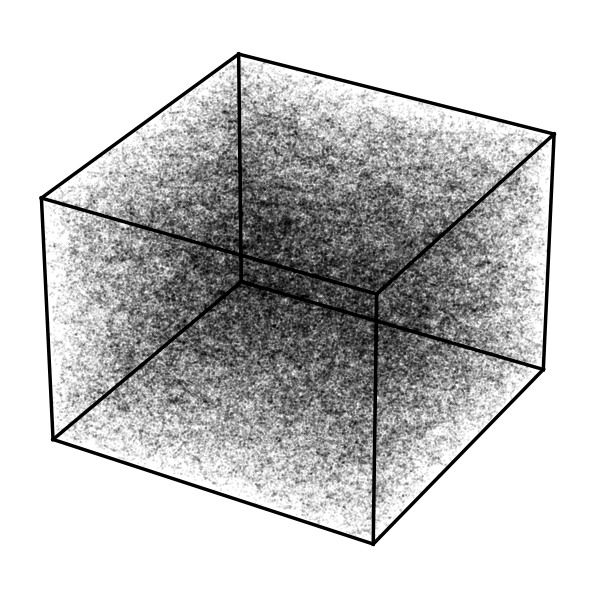

In [10]:
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Line3D


x, y, z = pos_halo[:, 0], pos_halo[:, 1], pos_halo[:, 2]

Lbox = 1000

def draw_box(ax, L, color='black', linewidth=2.5):
    r = [0, L]
    for s, e in [
        ((0,0,0), (L,0,0)), ((0,0,0), (0,L,0)), ((0,0,0), (0,0,L)),
        ((L,0,0), (L,L,0)), ((L,0,0), (L,0,L)),
        ((0,L,0), (L,L,0)), ((0,L,0), (0,L,L)),
        ((0,0,L), (L,0,L)), ((0,0,L), (0,L,L)),
        ((L,L,0), (L,L,L)), ((L,0,L), (L,L,L)), ((0,L,L), (L,L,L)),
    ]:
        line = Line3D(*zip(s, e), color=color, linewidth=linewidth)
        ax.add_line(line)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=0.05, alpha=0.2, color='black')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax.set_xlim(0, Lbox)
ax.set_ylim(0, Lbox)
ax.set_zlim(0, Lbox)

draw_box(ax, Lbox, color='black', linewidth=2.5)

ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)
ax.grid(False)

plt.tight_layout()
# plt.savefig('halo_box.png', dpi=300, transparent=True)
plt.show()


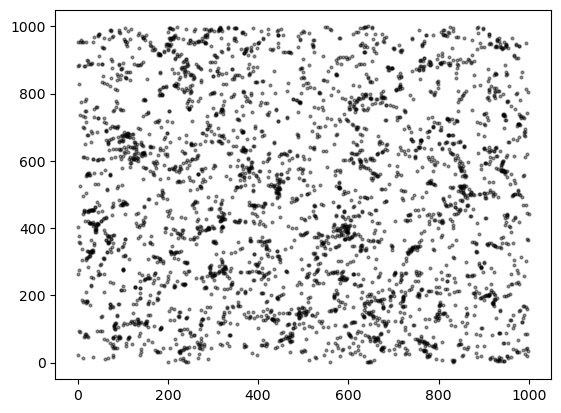

In [22]:
plt.scatter(x[(z>0) & (z<10)],y[(z>0) & (z<10)],s=4,color='k',alpha=0.4)

In [23]:
params = np.loadtxt('./data/BSQ_params.txt')

In [24]:
params

array([[0.28225995, 0.02676735, 0.71647832, 0.84342318, 0.97336542],
       [0.36990511, 0.07379601, 0.68728997, 1.1230911 , 0.79291034],
       [0.40535655, 0.04417873, 0.89734204, 0.99043181, 0.68721196],
       ...,
       [0.43573546, 0.06793803, 0.68772007, 1.05216591, 0.83948679],
       [0.38914936, 0.03831706, 0.87766793, 0.8348006 , 0.93419878],
       [0.25169685, 0.06300714, 0.52013717, 1.10513272, 0.70059505]],
      shape=(30000, 5))

Text(0, 0.5, '$\\sigma_8$')

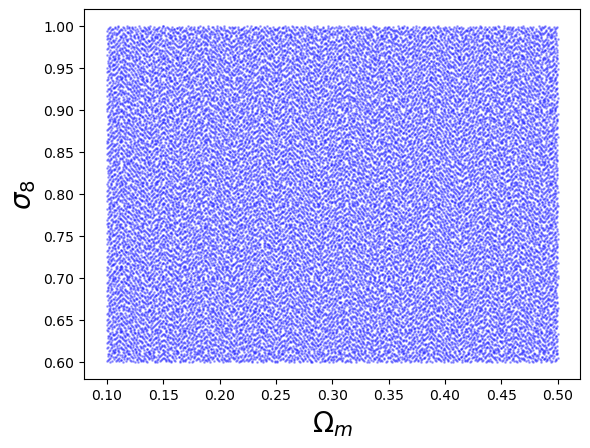

In [33]:
plt.scatter(params[:,0],params[:,4],s=1,color='b',alpha=0.3)
plt.xlabel(r'$\Omega_m$',fontsize=20)
plt.ylabel(r'$\sigma_8$',fontsize=20)

# Summart Statistics: Power Spectrum

In [36]:
with open('./data/power_BSQ_0_360_range_0_to_30000.pkl', 'rb') as file:
    data = pickle.load(file)

In [37]:
data

,k,Pk0,Pk2,Pk4
0,"[0.008899641224696954, 0.015079122165065578, 0...","[93476.06926166685, 97557.12256786063, 80170.2...","[-41290.66687377442, 66629.87947015, 22944.740...","[-7990.9587638124385, -16839.434440732777, 809..."
1,"[0.008899641224696954, 0.015079122165065578, 0...","[15150.202838549774, 42973.741617207525, 46806...","[-1660.810817400001, 25074.558632102435, 13604...","[-9716.3816274143, 3586.5533215011087, -43557...."
2,"[0.008899641224696954, 0.015079122165065578, 0...","[22184.890658895536, 29458.68493285149, 24321....","[-11176.6715527289, 37865.45928898263, 1017.93...","[-30656.624274567585, 610.3358452731483, -1130..."
3,"[0.008899641224696954, 0.015079122165065578, 0...","[950548.0780831724, 562972.6921475959, 466838....","[264943.7153500582, 503453.01641313033, 185892...","[2116989.507619839, -84705.0880327282, -113922..."
4,"[0.008899641224696954, 0.015079122165065578, 0...","[172011.3707950199, 203582.75427103863, 183689...","[11809.512342151169, 131181.29088992026, -1171...","[-314178.6892933538, -31543.080844197666, 1780..."
...,...,...,...,...
29995,"[0.008899641224696954, 0.015079122165065578, 0...","[834235.7363240016, 845472.278775004, 530114.1...","[-621940.3289787859, 626275.3658864787, 280691...","[-499278.97837707715, 45476.23098460433, -3740..."
29996,"[0.008899641224696954, 0.015079122165065578, 0...","[770853.0906776115, 737917.1512966135, 377675....","[235419.22718599398, 271142.8604799828, -30467...","[-1678541.1299779082, 512416.1683882101, -1311..."
29997,"[0.008899641224696954, 0.015079122165065578, 0...","[16911.460394953912, 34769.003035449976, 32599...","[1030.6199155024162, 23122.29488255875, 20657....","[-23724.629582060625, 162.28490228231956, 5581..."
29998,"[0.008899641224696954, 0.015079122165065578, 0...","[21499.623803814255, 33085.388690484, 44084.63...","[37050.426919259364, -6557.442239608213, 14345...","[15642.535940405589, 32153.761659076492, 6589...."


Text(0, 0.5, '$P(k)$')

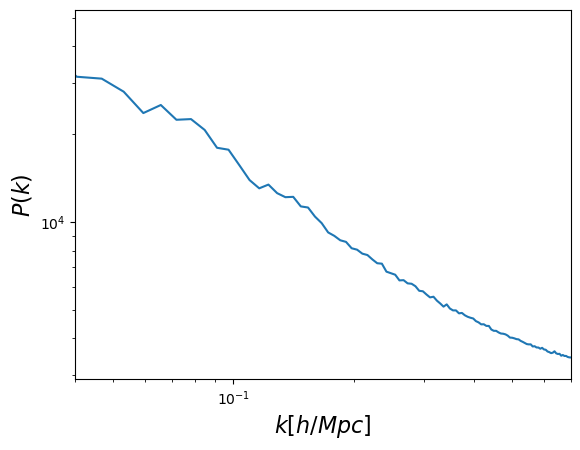

In [54]:
plt.plot(data['k'][1],data['Pk0'][1])
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.04,0.7)
plt.xlabel(r'$k[h/Mpc]$',fontsize=16)
plt.ylabel(r'$P(k)$',fontsize=16)

Text(0, 0.5, '$P(k)$')

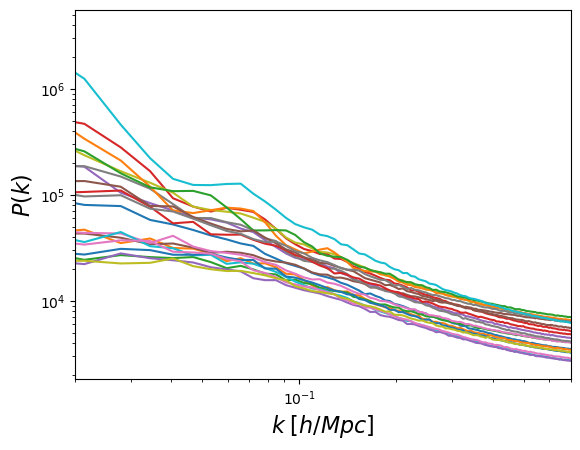

In [59]:
for i in range(20):
    plt.plot(data['k'][i],data['Pk0'][i])
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.02,0.7)
plt.xlabel(r'$k\;[h/Mpc]$',fontsize=16)
plt.ylabel(r'$P(k)$',fontsize=16)

# SBI Main Code

In [61]:
class PosteriorPredictor:
    def __init__(self, prior, parameters_path, data_configs, num_train_samples=500):
        self.prior = prior
        self.parameters_path = parameters_path
        self.data_configs = data_configs
        self.num_train_samples = num_train_samples
        self.inference = None
        self.posterior = None

    def load_data(self):
        parameters = np.loadtxt(self.parameters_path)
        data_parts = []
        for config in self.data_configs:
            with open(config['path'], 'rb') as file:
                data = pickle.load(file)
            if 'slice' in config and config['slice'] is not None:
                data_sliced = data.map(lambda x: x[config['slice_s']:config['slice']])
            else:
                data_sliced = data
            data_part = np.array(data_sliced[config['column']].tolist())
            data_parts.append(data_part)
        data_all = np.concatenate(data_parts, axis=1)
        train_data = data_all[:self.num_train_samples]
        train_parameters = parameters[:self.num_train_samples]
        return train_parameters, train_data, parameters, data_all

    def train_model(self):
        train_parameters, train_data, _, _ = self.load_data()
        x_train = torch.tensor(train_data, dtype=torch.float32)
        theta_train = torch.tensor(train_parameters, dtype=torch.float32)
        self.inference = SNPE(prior=self.prior)
        self.inference = self.inference.append_simulations(theta_train, x_train)
        density_estimator = self.inference.train()
        self.posterior = self.inference.build_posterior(density_estimator)
    
    def save_model(self, path):
        if self.posterior is None:
            raise ValueError("Posterior not available. Call train_model() first.")
        with open(path, 'wb') as f:
            dill.dump({
                'posterior': self.posterior,
                'data_configs': self.data_configs,
                'parameters_path': self.parameters_path,
                'prior': self.prior
            }, f)
        print(f"Posterior and configs saved to {path}")


    def load_model(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"Model file {path} not found.")
        with open(path, 'rb') as f:
            saved_data = dill.load(f)
        
        self.posterior = saved_data['posterior']
        self.data_configs = saved_data['data_configs']
        self.parameters_path = saved_data['parameters_path']
        self.prior = saved_data['prior']
        
        print(f"Posterior and configs loaded from {path}")


    def get_posterior_samples(self, x_o, num_samples=3000):
        if self.posterior is None:
            raise ValueError("Posterior not loaded or trained.")
        return self.posterior.sample((num_samples,), x=x_o, show_progress_bars=False)


In [63]:
data_configs_1 =  [
    {'path': f"./data/power_BSQ_0_360_range_0_to_30000.pkl",'column': 'Pk0', 'slice_s':0,'slice': 26}
]

In [67]:
prior = utils.BoxUniform(low=torch.tensor([0.1, 0.02, 0.5, 0.8, 0.6]), high=torch.tensor([0.5, 0.08, 0.9, 1.2, 1.0]))
predictor = PosteriorPredictor(
    prior=prior,
    parameters_path=f"./data/BSQ_params.txt",
    data_configs=data_configs_1,
    num_train_samples=28000
)
predictor.train_model()

 Neural network successfully converged after 164 epochs.

In [68]:
predictor.save_model("./models/model_01.pkl")

Posterior and configs saved to ./models/model_01.pkl


In [69]:
data_configs_2 =  [
    {'path': f"./data/power_BSQ_0_360_range_0_to_30000.pkl",'column': 'Pk0', 'slice_s':0,'slice': 26},
    {'path': f"./data/power_BSQ_0_360_range_0_to_30000.pkl",'column': 'Pk2', 'slice_s':0,'slice': 26},
    {'path': f"./data/power_BSQ_0_360_range_0_to_30000.pkl",'column': 'Pk4', 'slice_s':0,'slice': 26}
]

In [70]:
prior = utils.BoxUniform(low=torch.tensor([0.1, 0.02, 0.5, 0.8, 0.6]), high=torch.tensor([0.5, 0.08, 0.9, 1.2, 1.0]))
predictor = PosteriorPredictor(
    prior=prior,
    parameters_path=f"./data/BSQ_params.txt",
    data_configs=data_configs_2,
    num_train_samples=28000
)
predictor.train_model()

 Neural network successfully converged after 146 epochs.

In [71]:
predictor.save_model("./models/model_02.pkl")

Posterior and configs saved to ./models/model_02.pkl


## Model Loading

In [72]:
def load_posterior_samples(model_path, n, num_samples=3000, label=None):
    predictor = PosteriorPredictor(prior=None, parameters_path=None, data_configs=None)
    predictor.load_model(model_path)

    _, _, prediction_parameters, prediction_data = predictor.load_data()

    x_o = torch.tensor(prediction_data[n], dtype=torch.float32)

    posterior_samples = predictor.get_posterior_samples(x_o, num_samples=num_samples)

    ndim = posterior_samples.shape[1]
    names = [f"x{i}" for i in range(ndim)]
    labels = ['\Omega_m', '\Omega_b', 'h', 'n_s', '\sigma_8'][:ndim]

    if label is None:
        label = f"Sample {n}"

    samples = MCSamples(samples=np.array(posterior_samples), names=names, labels=labels, label=label)

    return samples, prediction_parameters


In [85]:
samples_1, prediction_parameters = load_posterior_samples("./models/model_01.pkl",
                                                          n=29000, num_samples=3000,
                                                          label="Power_0")


Posterior and configs loaded from ./models/model_01.pkl
Removed no burn in


/tmp/ipykernel_23596/180686548.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = MCSamples(samples=np.array(posterior_samples), names=names, labels=labels, label=label)


In [84]:
samples_2, prediction_parameters = load_posterior_samples("./models/model_02.pkl",
                                                          n=29000, num_samples=3000,
                                                          label="Power_024")


Posterior and configs loaded from ./models/model_02.pkl
Removed no burn in


/tmp/ipykernel_23596/180686548.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = MCSamples(samples=np.array(posterior_samples), names=names, labels=labels, label=label)


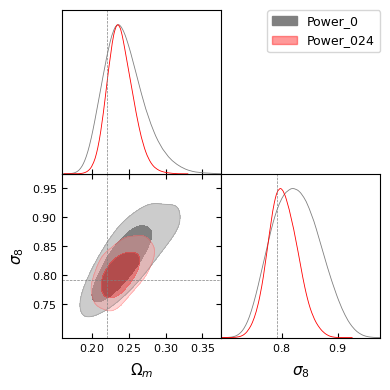

In [86]:
n = 29000
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples_1,samples_2], 
                ['x0', 'x4'], 
                filled=True,
                contour_colors=['gray','red','blue','green'],
                markers={'x0': prediction_parameters[n][0], 
                'x1': prediction_parameters[n][1], 
                'x2': prediction_parameters[n][2], 
                'x3': prediction_parameters[n][3], 
                'x4': prediction_parameters[n][4]})
# g.export("fig_1_revised.pdf")  # Saves in current working directory


In [88]:
def compute_metrics_for_models(model_paths, n_range, num_samples=3000):
    """
    Computes true parameters, posterior mean, std, and bias for multiple models.

    Args:
        model_paths: dict mapping model labels to file paths
        n_range: list or range of observation indices
        num_samples: number of posterior samples per observation

    Returns:
        results: dict[label] = {
            'true': [N, D],
            'mean': [N, D],
            'std': [N, D],
            'bias': [N, D]
        }
    """
    results = {}
    for label, path in model_paths.items():
        print(f"🔍 Processing model: {label}")
        predictor = PosteriorPredictor(prior=None, parameters_path=None, data_configs=None)
        predictor.load_model(path)
        _, _, prediction_parameters, prediction_data = predictor.load_data()

        true_list = []
        mean_list = []
        std_list = []
        bias_list = []

        for n in tqdm(n_range):
            x_o = torch.tensor(prediction_data[n], dtype=torch.float32)
            posterior_samples = predictor.get_posterior_samples(x_o, num_samples=num_samples)

            mean = posterior_samples.mean(axis=0)
            std = posterior_samples.std(axis=0)
            true_param = prediction_parameters[n]
            bias = mean - true_param

            true_list.append(true_param)
            mean_list.append(mean)
            std_list.append(std)
            bias_list.append(bias)

        results[label] = {
            'true': np.array(true_list),
            'mean': np.array(mean_list),
            'std': np.array(std_list),
            'bias': np.array(bias_list)
        }

    return results


In [89]:
model_paths = {
    "power_0": "./models/model_01.pkl",
    "power_024": "./models/model_02.pkl",
 }

n_range = range(28000, 30000)

results = compute_metrics_for_models(model_paths, n_range)

🔍 Processing model: power_0
Posterior and configs loaded from ./models/model_01.pkl


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_23596/165256601.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bias = mean - true_param
100%|██████████| 2000/2000 [00:53<00:00, 37.48it/s]


🔍 Processing model: power_024
Posterior and configs loaded from ./models/model_02.pkl


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_23596/165256601.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bias = mean - true_param
100%|██████████| 2000/2000 [00:53<00:00, 37.05it/s]


In [93]:
results

{'power_0': {'true': array([[0.29703666, 0.04586503, 0.58010068, 0.87938969, 0.68548535],
         [0.35938885, 0.05539415, 0.82200878, 1.16212459, 0.85502756],
         [0.41534791, 0.02508106, 0.61174911, 0.92639829, 0.97432303],
         ...,
         [0.43573546, 0.06793803, 0.68772007, 1.05216591, 0.83948679],
         [0.38914936, 0.03831706, 0.87766793, 0.8348006 , 0.93419878],
         [0.25169685, 0.06300714, 0.52013717, 1.10513272, 0.70059505]],
        shape=(2000, 5)),
  'mean': array([[0.2914116 , 0.04663048, 0.6129191 , 0.881134  , 0.6734017 ],
         [0.3777268 , 0.05291277, 0.8077825 , 1.1249096 , 0.9015374 ],
         [0.39280185, 0.03700706, 0.6798163 , 0.95087916, 0.93108726],
         ...,
         [0.42379993, 0.07131018, 0.6765585 , 1.0876064 , 0.85228705],
         [0.37443787, 0.04332747, 0.7159252 , 1.0088849 , 0.8907469 ],
         [0.26879802, 0.06867451, 0.62650216, 1.0050386 , 0.72342587]],
        shape=(2000, 5), dtype=float32),
  'std': array([[0.02181

In [90]:
import matplotlib.pyplot as plt

def plot_metric_vs_metric(results, param_indices, x_metric='true', y_metric='std', 
                          param_names=None, labels=None, save_path=None, figsize=(6, 4)):
    """
    Generalized plotting function to plot any metric vs another metric for multiple parameters and models.

    Args:
        results: dict[label] = {'true', 'mean', 'std', 'bias'}
        param_indices: list of int, indices of the parameters to plot
        x_metric: str, one of 'true', 'mean', 'std', 'bias'
        y_metric: str, one of 'true', 'mean', 'std', 'bias'
        param_names: optional list of names for parameters
        labels: optional dict[label] = display name for legend
        save_path: optional path to save the plot (e.g., 'plot.png')
        figsize: size of each subplot
    """
    num_params = len(param_indices)
    fig, axs = plt.subplots(1, num_params, figsize=(figsize[0]*num_params, figsize[1]), squeeze=False)
    
    for i, param_index in enumerate(param_indices):
        ax = axs[0, i]
        for label, data in results.items():
            x = data[x_metric][:, param_index]
            y = data[y_metric][:, param_index]
            display_label = labels[label] if labels else label
            ax.scatter(x, y, s=10, alpha=0.6, label=display_label)

        x_label = f"{x_metric}({param_names[param_index]})" if param_names else f"{x_metric}[{param_index}]"
        y_label = f"{y_metric}({param_names[param_index]})" if param_names else f"{y_metric}[{param_index}]"
        ax.set_xlabel(x_label, fontsize=11)
        ax.set_ylabel(y_label, fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")
    plt.show()


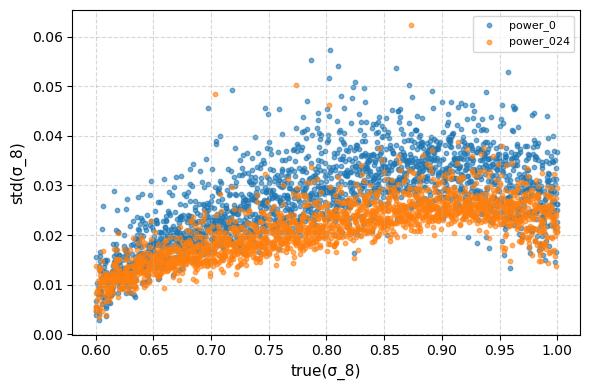

In [91]:
param_names = ['Ω_m', 'Ω_b', 'h', 'n_s', 'σ_8']
param_indices = [4]  
# std vs true
plot_metric_vs_metric(results, param_indices, x_metric='true', y_metric='std', param_names=param_names)

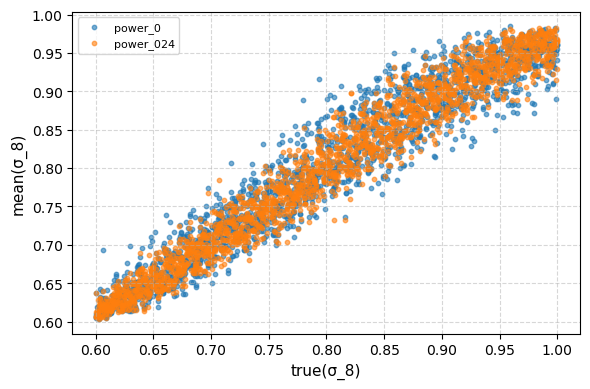

In [92]:
param_names = ['Ω_m', 'Ω_b', 'h', 'n_s', 'σ_8']
param_indices = [4]  
# std vs true
plot_metric_vs_metric(results, param_indices, x_metric='true', y_metric='mean', param_names=param_names)